In [1]:
import pandas as pd
import numpy as np

In [2]:
data = "C:\\Users\\Dell\\Desktop\\hotel_bookings.csv"

In [3]:
df = pd.read_csv(data)

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df['agent'].value_counts()

agent
9.0      31961
240.0    13922
1.0       7191
14.0      3640
7.0       3539
         ...  
289.0        1
432.0        1
265.0        1
93.0         1
304.0        1
Name: count, Length: 333, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
#we have missing values: agent, children, country, company
# fill children with 0, country with unknown and drop agent and company because of high number of missing values

df['children'].fillna(0, inplace=True)
df['country'].fillna('Unknown', inplace=True)
df.drop(columns=['agent', 'company'], inplace=True)

Encode categorical variables

In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

encoded_features = encoder.fit_transform(df[['hotel', 'customer_type', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type']])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['hotel', 'customer_type', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type']))

df = pd.concat([df, encoded_df], axis=1)

df.drop(columns=['hotel', 'customer_type', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type'], inplace=True)


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
cat_feat = df.select_dtypes(include='object')
cat_feat.columns

Index(['reservation_status', 'reservation_status_date'], dtype='object')

In [10]:
df.drop(columns=['reservation_status', 'reservation_status_date'], inplace= True)

##### Modeling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [12]:
df['is_canceled'].value_counts() #data distribution is imbalanced so we will use SMOTE technique to balance it

is_canceled
0    75166
1    44224
Name: count, dtype: int64

In [13]:
X = df.drop(columns = ['is_canceled'])
y = df['is_canceled']

In [14]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE object 
smote = SMOTE(random_state = 42)

# Fit and resample the dataset
X, y = smote.fit_resample(X, y)

In [15]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Random Forest Classifier

In [16]:
# Initialize random forest object
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
rf_pred = rf.predict(X_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, rf_pred)

print("Random Forest Classifier (Without grid search):")
print(f'Accuracy: {accuracy_rf:.2f}')
print('Classification Report:')
print(classification_report(y_test, rf_pred))

Random Forest Classifier (Without grid search):
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     15187
           1       0.92      0.89      0.91     14880

    accuracy                           0.91     30067
   macro avg       0.91      0.91      0.91     30067
weighted avg       0.91      0.91      0.91     30067



Support Vector Classifier

In [18]:
# # Initialize svc object
# svc = SVC(random_state=42)

# # fit training data
# svc.fit(X_train, y_train)

# # make predictions
# svc_pred = svc.predict(X_test)

In [19]:
# # Evaluate accuracy
# accuracy_svc = accuracy_score(y_test, svc_pred)
# classification_svc = classification_report(y_test, svc_pred)

# print("Support Vector Classifier (without grid search): ")
# print(f"Accuracy : {accuracy_svc :2f}")
# print("Classification Report:")
# print(classification_svc)

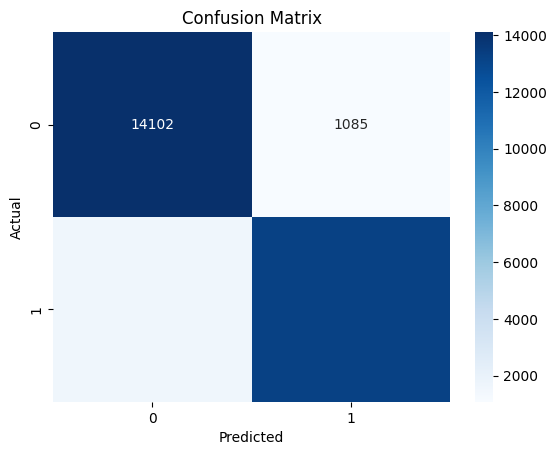

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#confusion matrix